In [1]:
import pandas as pd
import itertools
import matplotlib as mpl
from pandas_datareader import data as pd_data
import statsmodels.api as sm
from linearmodels import iv

/home/sangrey/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')

## Bloomberg Dates

In [3]:
dates = pd.read_excel('../data/macro_announcement_dates_2003_2017.xlsx').iloc[:-2]
dates['Date Time'] = pd.to_datetime(dates['Date Time'])      
dates.drop(axis=1, labels=['Unnamed: {}'.format(n) for n in range(1,6) if n != 4], inplace=True)
construct_revision_2 = 'U.S. Releases Construction Spending Revisions' 
factor_ord_2 = 'Factory Orders Ex Trans'
dates.query('Event != @construct_revision_2 & Event != @factor_ord_2', inplace=True)
dates['Count'] = np.ones(dates.shape[0])

In [4]:
count_table = dates.pivot_table(columns='Event', values='Count', index='Date Time').fillna(0)
relevance_table = dates.pivot_table(columns='Event', values='Relevance', index='Date Time').fillna(0)
count_table.columns = ['Capacity_Util', 'Durable_Orders', 'Factory_Orders', 'Industrial_Prod', 'Manufacturing_PMI',
                       'Construction_Spend']
relevance_table.columns = ['Capacity_Util', 'Durable_Orders', 'Factory_Orders', 'Industrial_Prod',
                           'Manufacturing_PMI']
                       

In [5]:
pivoted_df = pd.merge(count_table, relevance_table, left_index=True, right_index=True, 
                      suffixes=[' Count', ' Relevance'])

Date Time
2003-01-07 10:00:00    1.0
2003-01-17 09:15:00    2.0
2003-01-28 08:30:00    1.0
2003-02-04 10:00:00    1.0
2003-02-14 09:15:00    2.0
dtype: float64

## Import Vol Data

In [6]:
%matplotlib inline
np.set_printoptions(precision=6)
pd.options.display.precision = 6
mpl.pyplot.style.use('seaborn-talk')
presentation_fontsize=22
mpl.rc('legend', **{'fontsize':presentation_fontsize})
mpl.rc('axes', **{'labelsize':presentation_fontsize, 'titlesize':presentation_fontsize})
mpl.rc('xtick', **{'labelsize':presentation_fontsize})
mpl.rc('ytick', **{'labelsize': presentation_fontsize})

In [39]:
with pd.HDFStore('../results/spy_volatility_estimates_2003-2017.hdf') as volatility_store:
    discrete_vol = volatility_store['discrete_trunc_vol']['2003':]
daily_rtn = pd.read_csv('../data/spy_daily_data_2000-2017.csv', index_col=0, parse_dates=True).rename(
                        columns={'log_rtn':'daily_rtn'}).daily_rtn
discrete_vol['quad'] = discrete_vol['jumps'] + discrete_vol['diffusion']
fed_announcement_dates = pd.read_hdf('../results/fomc_times.hdf', 'table')
dates = pd.DataFrame(np.ones((fed_announcement_dates.size,1)), 
                     index=fed_announcement_dates['FOMC_times']).resample('D').last().fillna(0).rename(
    columns={0:'fomc_dates'})
treasury_yield = pd_data.get_data_fred('DGS10', start='1950', end='2018').apply(
    lambda x: np.log(x/(100 * 365) + 1)).rename(columns={'DGS10':'log_yield'})
daily_rtn = 252 * (daily_rtn - treasury_yield.T).T.rename(columns={'log_yield':'daily_rtn'}).dropna()
jump_prop = (discrete_vol['jumps'].apply(np.log) - discrete_vol['quad'].apply(np.log)).dropna().to_frame().rename(
    columns={0:'log_prop'})
log_vol = discrete_vol.apply(np.log).dropna()
log_vol.columns = ['log_' + val for val in discrete_vol.columns]
weights = ((discrete_vol.quad * 252)**(-1)).to_frame().rename(columns={'quad':'weights'})
bloomberg_dates = count_table.sum(axis=1).to_frame().rename(
    columns={0:'bloomberg'}).resample('D').mean().replace(np.nan, 0)

## Compare with Jump Proportion

In [41]:
data = pd.concat([dates, discrete_vol, jump_prop, daily_rtn,log_vol, bloomberg_dates], axis=1).dropna()

In [42]:
data.head()

fomc_dates  diffusion     jumps      quad  log_prop  daily_rtn  \
2003-01-07         0.0   0.000159  0.000082  0.000241 -1.076754  -2.275851   
2003-01-08         0.0   0.000113  0.000093  0.000206 -0.792770  -3.699711   
2003-01-09         0.0   0.000079  0.000076  0.000155 -0.715640   4.023752   
2003-01-10         0.0   0.000155  0.000101  0.000256 -0.927899   0.161357   
2003-01-14         0.0   0.000107  0.000072  0.000179 -0.904222   0.467265   

            log_diffusion  log_jumps  log_quad  bloomberg  
2003-01-07      -8.745836  -9.406015 -8.329260        1.0  
2003-01-08      -9.090522  -9.280736 -8.487966        0.0  
2003-01-09      -9.443996  -9.488488 -8.772848        0.0  
2003-01-10      -8.775146  -9.199884 -8.271985        0.0  
2003-01-14      -9.146919  -9.532188 -8.627966        0.0

In [43]:
data.corr()

fomc_dates  diffusion     jumps      quad  log_prop  daily_rtn  \
fomc_dates       1.000000   0.022768  0.030948  0.025820 -0.068519   0.073836   
diffusion        0.022768   1.000000  0.942447  0.993637 -0.338355  -0.124528   
jumps            0.030948   0.942447  1.000000  0.974108 -0.283544  -0.146103   
quad             0.025820   0.993637  0.974108  1.000000 -0.324299  -0.133417   
log_prop        -0.068519  -0.338355 -0.283544 -0.324299  1.000000   0.108953   
daily_rtn        0.073836  -0.124528 -0.146103 -0.133417  0.108953   1.000000   
log_diffusion    0.081171   0.560458  0.672795  0.605598 -0.573103  -0.162179   
log_jumps        0.070434   0.536982  0.686022  0.594179 -0.295073  -0.148049   
log_quad         0.077600   0.560399  0.690712  0.611593 -0.446025  -0.157163   
bloomberg       -0.003670  -0.019852 -0.025817 -0.022120  0.016258   0.003684   

               log_diffusion  log_jumps  log_quad  bloomberg  
fomc_dates          0.081171   0.070434  0.077600  -0.003670  
diffusion           0.560458   0.536982  0.560399  -0.019852  
jumps               0.672795   0.686022  0.690712  -0.025817  
quad                0.605598   0.594179  0.611593  -0.022120  
log_prop           -0.573103  -0.295073 -0.446025   0.016258  
daily_rtn          -0.162179  -0.148049 -0.157163   0.003684  
log_diffusion       1.000000   0.950711  0.987769  -0.047679  
log_jumps           0.950711   1.000000  0.986779  -0.048487  
log_quad            0.987769   0.986779  1.000000  -0.048176  
bloomberg          -0.047679  -0.048487 -0.048176   1.000000

In [49]:
announcement_dates_formula = 'log_prop ~ fomc_dates + bloomberg'
announcement_mdl = iv.IVGMM.from_formula(announcement_dates_formula, data=data.dropna()).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
announcement_mdl

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:               log_prop   R-squared:                      0.0050
Estimator:                     IV-GMM   Adj. R-squared:                 0.0043
No. Observations:                2895   F-statistic:                    16.731
Date:                Sat, Jan 13 2018   P-value (F-stat)                0.0002
Time:                        10:32:50   Distribution:                  chi2(2)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -0.6892     0.0104    -66.497     0.0000     -0.7095     -0.6689
fomc_dates    -0.0592     0.0162    -3.6584     0.0003     -0.0910     -0.0275
bloomberg      0.0049     0.0042     1.1691     0.2424     -0.0033      0.0132
==============================================================================
IVGMMResults, id: 0x7fb02aa64e10

In [50]:
announcement_dates_formula = 'log_prop ~ fomc_dates + bloomberg'
announcement_madl = iv.IVGMM.from_formula(announcement_dates_formula, data=data.dropna()).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
announcement_mdl

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:               log_prop   R-squared:                      0.0050
Estimator:                     IV-GMM   Adj. R-squared:                 0.0043
No. Observations:                2895   F-statistic:                    16.731
Date:                Sat, Jan 13 2018   P-value (F-stat)                0.0002
Time:                        10:32:50   Distribution:                  chi2(2)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -0.6892     0.0104    -66.497     0.0000     -0.7095     -0.6689
fomc_dates    -0.0592     0.0162    -3.6584     0.0003     -0.0910     -0.0275
bloomberg      0.0049     0.0042     1.1691     0.2424     -0.0033      0.0132
==============================================================================
IVGMMResults, id: 0x7fb02aa64e10

In [61]:
data.log_prop.apply(np.exp).sort_values(ascending=False).head(20)

2007-01-04    0.896794
2008-07-25    0.888970
2013-12-24    0.844142
2009-12-24    0.831734
2009-12-31    0.824211
2004-03-02    0.820811
2005-03-01    0.791058
2009-12-23    0.789085
2006-12-28    0.782038
2007-09-18    0.778840
2005-06-08    0.776593
2014-12-24    0.764003
2010-12-31    0.760018
2015-05-14    0.759957
2012-08-30    0.747346
2006-12-27    0.742410
2004-08-24    0.737248
2009-07-02    0.735765
2014-07-22    0.732595
2004-10-01    0.728634
Name: log_prop, dtype: float64

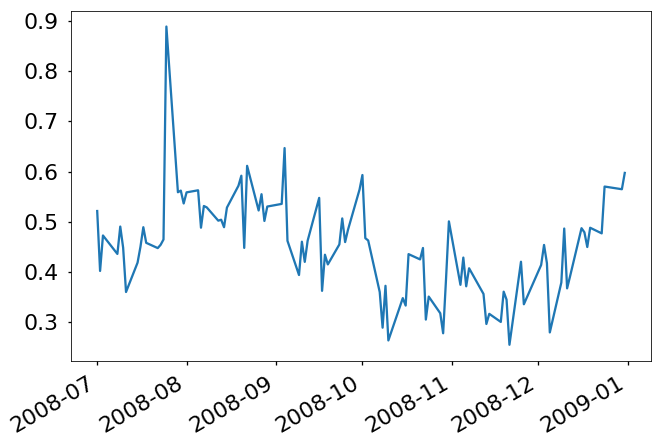

In [62]:
data['2008-07':'2008-12'].log_prop.apply(np.exp).plot()

In [59]:
data['2008-07':'2008-12'].log_prop.apply(np.exp).sort_values(ascending=False).head()

2008-07-25    0.888970
2008-09-04    0.646912
2008-08-22    0.611525
2008-12-31    0.597437
2008-10-01    0.593239
2008-08-20    0.591821
2008-08-19    0.571893
2008-12-24    0.570258
2008-12-30    0.564926
2008-09-30    0.564246
2008-08-05    0.562806
2008-07-30    0.562161
2008-07-29    0.558934
2008-08-01    0.558675
2008-08-27    0.555019
2008-09-16    0.547681
2008-07-31    0.536544
2008-09-03    0.535702
2008-08-07    0.531510
2008-08-29    0.530449
Name: log_prop, dtype: float64

In [65]:
data['2008'].fomc_dates.sort_values(ascending=False).head(8)

2008-01-30    1.0
2008-06-25    1.0
2008-09-16    1.0
2008-10-29    1.0
2008-08-05    1.0
2008-12-16    1.0
2008-03-18    1.0
2008-04-30    1.0
Name: fomc_dates, dtype: float64